In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

adv_cols = ['stuffed','mediocre', 'explosive', 'huge_play', 'first_down', 'short_first', 'epa', 'yards_gained']

x_cols = game_context_cols + adv_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [3]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown
    ,rusher_player_name
    ,rusher_id,
                     pbp.season,
					 pbp.week,
                     fantasy_player_name,
                     qb_scramble,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	adv.*,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	join rusher_adv as adv on pbp.rusher_player_id = adv.gsis_id
	and pbp.season = adv.season
	and pbp.week = adv.week
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")

rushes2 = rushes.copy()
mask = rushes.yards_gained < (rushes.yardline_100 - 10)
rushes2.loc[mask, 'yards_shifted'] += np.random.randint(-2,3, size=mask.sum())
print(len(rushes2))


264860


In [4]:
rushes.iloc[4]

desc                   (8:45) 34-R.Williams right end ran ob at MIA 4...
game_id                                                   2002_09_MIA_GB
yards_gained                                                         6.0
yards_shifted                                                       46.0
is_first_down                                                          0
is_second_down                                                         1
is_third_down                                                          0
is_fourth_down                                                         0
first_down                                                           1.0
touchdown                                                            0.0
rusher_player_name                                           R. Williams
rusher_id                                                     00-0017915
season                                                              2002
week                                               

In [5]:
data = pd.concat((rushes, rushes2))
X = data[x_cols]
y = data['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [6]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.006)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	#train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	#test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			#batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 2
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) 
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [7]:

rush_yards_model = train_model(X_tensor,y_tensor, n_in=len(x_cols), n_out=140, n_hidden = 128, epochs=10, batch_size=2048)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 
#Test Loss: 2.8056, Test Accuracy: 0.1470 fixed td bug, this looks best even w/ low acc. no focal loss or smooth labels
#Test Loss: 2.9683, Test Accuracy: 0.1199
#

cuda
tensors loading
splitting batches
tensor(0.2458, device='cuda:0')
tensor(0.0332, device='cuda:0')


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

true_first=0.12, true_td=0.02
fd_model=0.15, td_model=0.01
Actual mean: 4.39, Model mean: 4.70
number of datapoints: 1698


(-10.0, 45.0)

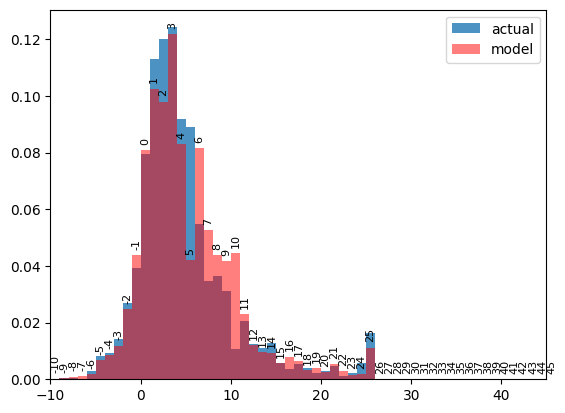

In [ ]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 25
down = 2
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')
3
# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard + 20:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [ ]:
def sample_model_yardline(yard, down):
	sample = rushes#.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	
	return probs

probs = sample_model_yardline(10,4)
probs

true_first=0.24, true_td=0.03
fd_model=0.29, td_model=0.03


array([[6.59027081e-15, 5.87919851e-15, 4.69166069e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.18757770e-17, 3.69441063e-17, 1.00272106e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.68805876e-16, 7.71480149e-16, 7.62295609e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.35242584e-09, 1.23420762e-09, 3.21397842e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.26397419e-13, 2.02222259e-13, 6.78085990e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.58936796e-11, 2.33914745e-11, 1.93879046e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(349520, 140), dtype=float32)

In [ ]:
rushes['pred'] = torch.sum(torch.tensor((probs * np.arange(-40,100))),dim=1)
rushes

,desc,game_id,yards_gained,yards_shifted,is_first_down,is_second_down,is_third_down,is_fourth_down,first_down,touchdown,...,fantasy_player_name,qb_scramble,short_to_first,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,pred
0,(15:00) T.Jones left end to ARI 37 for 2 yards...,2000_01_ARI_NYG,2.0,42.0,1,0,0,0,0.0,0.0,...,T.Jones,0.0,0,65.0,10.0,1.0,0.0,6.5,40.0,5.341168
1,(13:40) T.Barber right tackle to NYG 30 for 8 ...,2000_01_ARI_NYG,8.0,48.0,1,0,0,0,0.0,0.0,...,T.Barber,0.0,0,78.0,10.0,1.0,0.0,6.5,40.0,5.157651
2,(13:40) R.Dayne right guard to NYG 33 for 3 ya...,2000_01_ARI_NYG,3.0,43.0,0,1,0,0,1.0,0.0,...,R.Dayne,0.0,1,70.0,2.0,2.0,0.0,6.5,40.0,4.513602
3,(13:40) T.Barber left end pushed ob at NYG 32 ...,2000_01_ARI_NYG,-1.0,39.0,1,0,0,0,0.0,0.0,...,T.Barber,0.0,0,67.0,10.0,1.0,0.0,6.5,40.0,5.329234
4,(10:59) R.Dayne right tackle to ARI 39 for 3 y...,2000_01_ARI_NYG,3.0,43.0,0,1,0,0,0.0,0.0,...,R.Dayne,0.0,0,42.0,10.0,2.0,0.0,6.5,40.0,5.848772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349515,(4:11) (Shotgun) 31-N.Miller-Hines right tackl...,2025_08_MIN_LAC,1.0,41.0,1,0,0,0,0.0,0.0,...,N.Miller-Hines,0.0,0,24.0,10.0,1.0,0.0,3.0,45.5,4.753132
349516,(3:26) 31-N.Miller-Hines right guard to MIN 26...,2025_08_MIN_LAC,-3.0,37.0,0,1,0,0,0.0,0.0,...,N.Miller-Hines,0.0,0,23.0,9.0,2.0,0.0,3.0,45.5,5.106676
349517,(2:44) 32-J.Patterson left end to MIN 27 for -...,2025_08_MIN_LAC,-1.0,39.0,0,0,1,0,0.0,0.0,...,J.Patterson,0.0,0,26.0,12.0,3.0,0.0,3.0,45.5,6.045764
349518,(1:46) (Shotgun) 36-Z.Scott right tackle to LA...,2025_08_MIN_LAC,6.0,46.0,0,1,0,0,0.0,0.0,...,Z.Scott,0.0,0,55.0,10.0,2.0,0.0,3.0,45.5,6.151568


In [ ]:
rushes['RYOE'] = rushes['yards_gained'] - rushes['pred']


In [ ]:
ex = rushes.loc[rushes.season ==2022].groupby(['rusher_player_name', 'qb_scramble'])['RYOE'].mean().reset_index().sort_values(by='RYOE')
cnt = rushes.loc[rushes.season == 2022]['rusher_player_name'].value_counts().reset_index()
ex = ex.merge(cnt)
ex.loc[(ex['count'] > 40) & (ex.qb_scramble == 0)].sort_values(by='RYOE').head(30)

,rusher_player_name,qb_scramble,RYOE,count
30,C.Edwards-Helaire,0.0,-6.019646,69
59,J.Jackson,0.0,-3.875205,41
61,D.Henderson,0.0,-3.801169,69
62,A.Mattison,0.0,-3.799035,74
64,Z.Knight,0.0,-3.764715,82
67,E.Benjamin,0.0,-3.708816,75
72,M.Ingram,0.0,-3.593115,61
75,R.White,0.0,-3.528638,135
78,D.Ogunbowale,0.0,-3.440407,42
86,A.Gibson,0.0,-3.106703,146


In [ ]:
rushes.groupby(['qb_scramble'])[['yards_gained', 'RYOE']].mean()

,yards_gained,RYOE
qb_scramble,,
0.0,4.204482,-2.226986
1.0,7.356793,0.641242


In [ ]:
ex.loc[ex.rusher_player_name.str.contains('C.McCaff')]

,rusher_player_name,qb_scramble,RYOE,count
191,C.McCaffrey,0.0,-1.745715,279


In [ ]:
out.loc[-1]

KeyError: -1

5.34


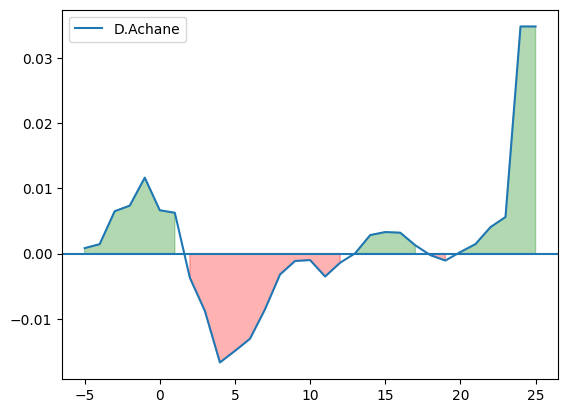

In [ ]:
def vis_rusher(name):
	r1 = rushes.loc[
		(rushes.rusher_player_name == name) & (rushes.season == 2025), "yards_gained"
	]
	print(r1.mean().round(2))
	r1 = r1.apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	r_ = rushes.loc[
		(rushes.season >= 2023), "yards_gained"
	].apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	out = r1.merge(r_, on ='yards_gained', how='right')
	out['proportion_x'] = out['proportion_x'].fillna(0)
	out['di'] = (out['proportion_x'] - out['proportion_y']).fillna(0)
	out = out.sort_values(by='yards_gained')
	out['di'] = out['di'].rolling(5, min_periods=0, center=True).mean().rolling(3, min_periods=0, center=True).mean()
	out.loc[out.index[-1], 'di'] = out['proportion_x'].iloc[-1]
	out.loc[out.index[-2], 'di'] = out['proportion_x'].iloc[-1]
	out = out.loc[out.yards_gained > -6]
	plt.axhline(0)
	x = out['yards_gained']
	y = out['di']
	plt.plot(x,y, label=name)
	plt.fill_between(x, y, 0, where=(y>0), color='green', alpha=0.3)
	plt.fill_between(x, y, 0, where=(y<0), color='red', alpha=0.3)
	#plt.show()
	return out

out = vis_rusher('D.Achane')

#vis_rusher('C.McCaffrey')
plt.legend()

In [ ]:
choices = rushes.loc[rushes.season==2025,'rusher_player_name'].value_counts().head(50).index.values

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown
dropdown = widgets.Dropdown(
    options=choices,
    value=choices[0],  # default value
    description='Choose:',
)


@widgets.interact(choice=choices)
def f(choice):
    vis_rusher(choice)


interactive(children=(Dropdown(description='choice', options=('B.Robinson', 'J.Taylor', 'C.McCaffrey', 'J.Will…